In [60]:
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
def lgb_objective(trial):
    # Define hyperparameters space using trial object
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # Create a dataset for LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Train the model
    model = lgb.train(param, train_data, valid_sets=[valid_data], early_stopping_rounds=50, verbose_eval=False)
    
    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

In [63]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [64]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [65]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [66]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
dtype: int64


In [67]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

df['Year'] = df['Date'].apply(lambda x: 2000 + int(str(x)[:2]))  # Adding 2000 to get the full year, e.g., 2015
df['Month'] = df['Date'].apply(lambda x: int(str(x)[2:4]))
df['Day'] = df['Date'].apply(lambda x: int(str(x)[4:6]))
df['Hour'] = df['Date'].apply(lambda x: int(str(x)[6:]))

In [68]:
df = df.drop(columns = ['Date', 'Code', 'Locale'])

In [31]:
df = df.drop(columns = ['SO2', 'CO','PM10','PM2_5'])

<AxesSubplot:>

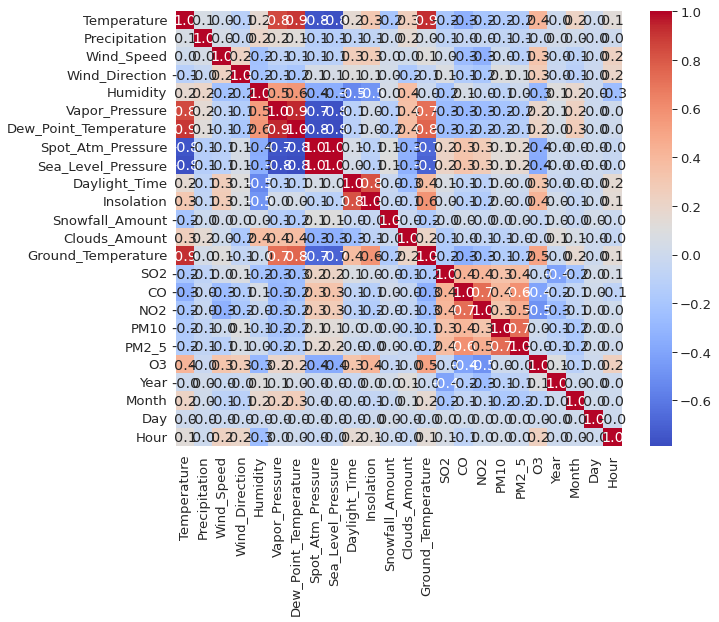

In [69]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [70]:
# Specify the target variable
y = df['O3']

In [71]:
# Specify the feature variables
X = df.drop(['O3'], axis=1)

In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 60, 90],
    'min_child_samples': [20, 30, 40]
}

In [16]:
# Initialize LGBMRegressor
lgbm = lgb.LGBMRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(lgbm, param_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Initialize LGBMRegressor with the best parameters
model = grid_search.best_estimator_

# Fit the model
model.fit(X_train, y_train)

In [73]:
# Create a study object and specify the direction is 'minimize'.
study = optuna.create_study(direction='minimize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(lgb_objective, n_trials=100)  # You can adjust the number of trials

# Results
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
best_params = study.best_params
train_full_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train(best_params, train_full_data)

[I 2023-08-19 19:53:49,000] A new study created in memory with name: no-name-2d9839a3-964e-4fa4-b8bc-561cc395797e
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-08-19 19:53:50,892] Trial 0 finished with value: 0.008590240188687976 and parameters: {'lambda_l1': 2.614480053755321, 'lambda_l

Best trial:
  Value: 0.005606362019100768
  Params: 
    lambda_l1: 0.00011258655255849509
    lambda_l2: 2.319543183338227e-05
    num_leaves: 255
    feature_fraction: 0.8114638571289469
    bagging_fraction: 0.9528969748329726
    bagging_freq: 6
    min_child_samples: 16
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 56102, number of used features: 23
[LightGBM] [Info] Start training from score 0.025331


In [74]:
# Make predictions
predictions = model.predict(X_test)

In [75]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.005606


In [76]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.003870


In [77]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.914674


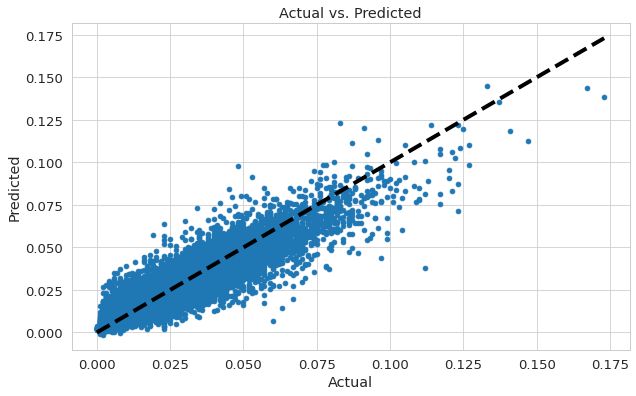

In [27]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

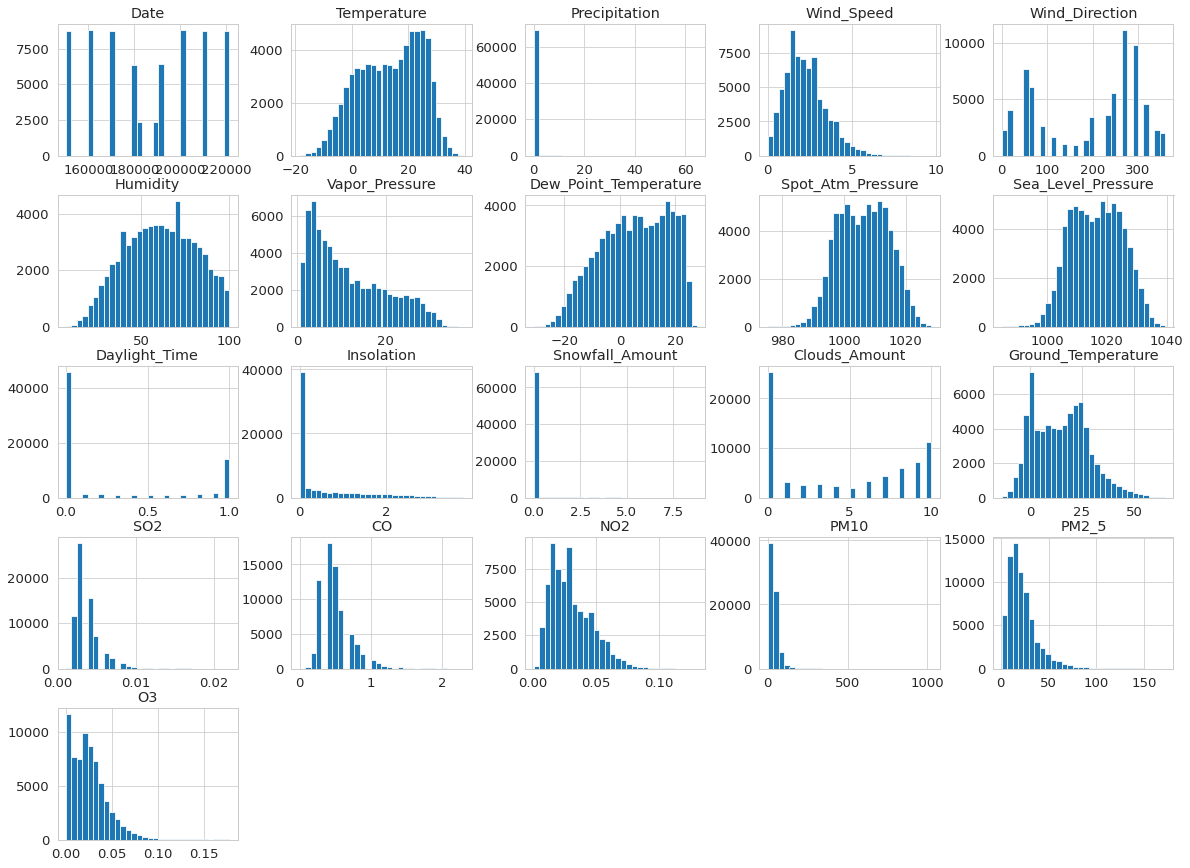

In [28]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

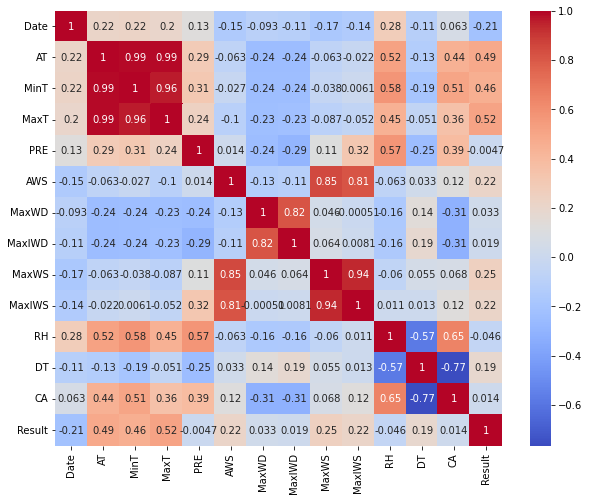

In [30]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

ValueError: num must be 1 <= num <= 15, not 16

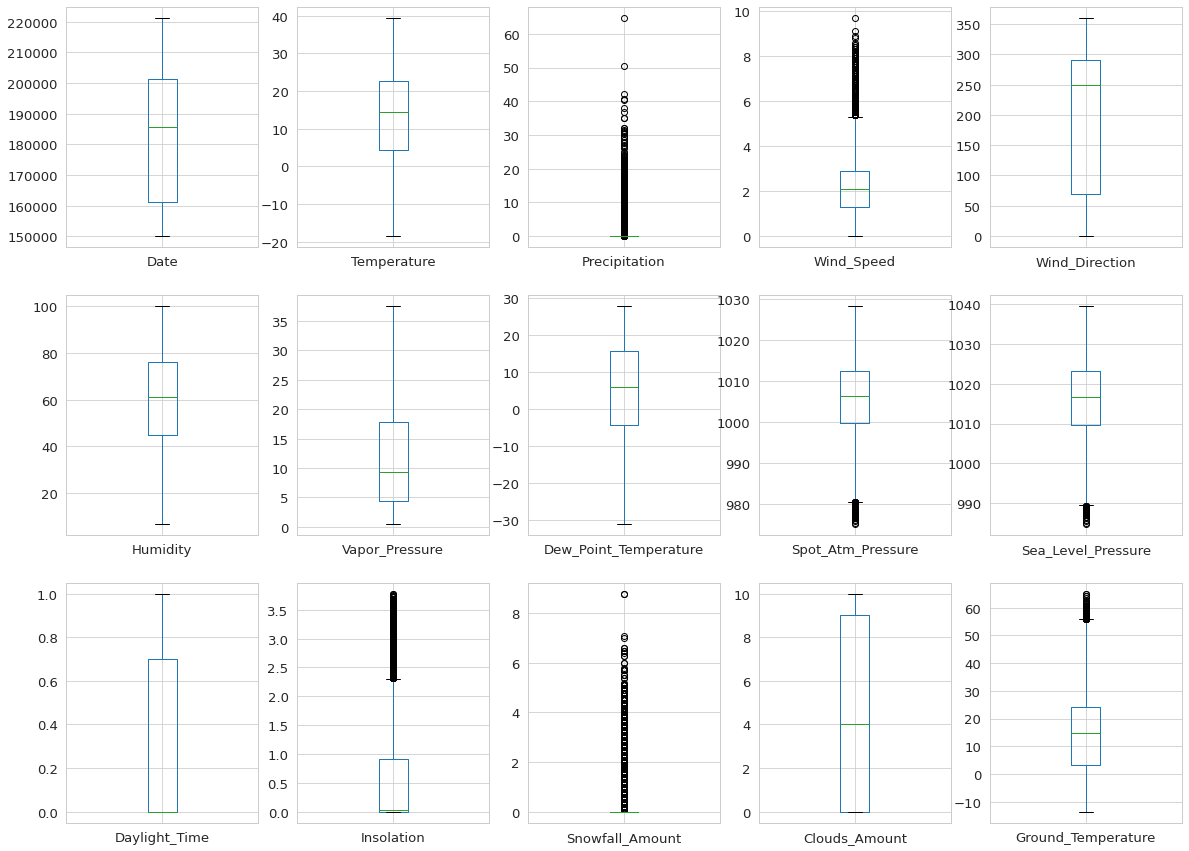

In [29]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()